<a href="https://colab.research.google.com/github/bendavidsteel/trade-democratization/blob/master/trade_diffusion_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch==1.5.1+cu101 torchvision==0.6.1+cu101 -f https://download.pytorch.org/whl/torch_stable.html
!pip install torch-scatter==2.0.4+cu101 -f https://pytorch-geometric.com/whl/torch-1.5.0.html
!pip install torch-sparse==0.6.5+cu101 -f https://pytorch-geometric.com/whl/torch-1.5.0.html
!pip install torch-cluster==1.5.5+cu101 -f https://pytorch-geometric.com/whl/torch-1.5.0.html
!pip install torch-spline-conv==1.2.0+cu101 -f https://pytorch-geometric.com/whl/torch-1.5.0.html
!pip install torch-geometric

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 704.4MB 25kB/s 
     |████████████████████████████████| 6.6MB 28.0MB/s 
  Found existing installation: torch 1.6.0+cu101
    Uninstalling torch-1.6.0+cu101:
      Successfully uninstalled torch-1.6.0+cu101
  Found existing installation: torchvision 0.7.0+cu101
    Uninstalling torchvision-0.7.0+cu101:
      Successfully uninstalled torchvision-0.7.0+cu101
Looking in links: https://pytorch-geometric.com/whl/torch-1.5.0.html
     |████████████████████████████████| 12.3MB 2.4MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.5.0.html
     |████████████████████████████████| 21.6MB 229kB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.5.0.html
     |████████████████████████████████| 22.0MB 191kB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.5.0.html
     |████████████████████████████████| 6.3MB 2.0MB/s 
     |████████████████████████████

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!cp "/content/drive/My Drive/projects/trade_democratization/trade/utils.py" .
!cp "/content/drive/My Drive/projects/trade_democratization/trade/nets.py" .

In [ ]:
import itertools
import json
import math
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch_geometric as geo
import tqdm

import nets
import utils

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
root = os.path.join('/', 'content', 'drive', 'My Drive', 'projects', 'trade_democratization')

# Read data into Data object.
vdem_nodes = pd.read_csv(os.path.join(root, "dataset", "raw", "V-Dem-CY-Core-v10.csv"))

tradhist_timevar_frames = []
for idx in range(1, 4):
    tradhist_timevar_frames.append(pd.read_excel(os.path.join(root, "dataset", "raw", "TRADHIST_GRAVITY_BILATERAL_TIME_VARIANT_{}.xlsx".format(idx))))
tradhist_timevar = pd.concat(tradhist_timevar_frames)

In [ ]:
country_mapping = utils.get_mapping(vdem_nodes, tradhist_timevar)

In [ ]:
def full_sequence():
    dataset = torch.load(os.path.join(root, "dataset", "processed", 'traddem_series.pt'))

    seq_len = len(dataset) + len(dataset[-1].sequence) - 1
    num_countries = len(country_mapping)
    num_targets = 1

    initial = dataset[0].initial
    y = torch.zeros(seq_len, num_countries, num_targets, dtype=torch.float32)

    full_sequence = []
    for idx, seq in enumerate(dataset):
        full_sequence.append(seq.sequence[0])
        y[idx, :, :] = seq.target[0, :, :]

    for idx in range(1, len(dataset[-1].sequence)):
        full_sequence.append(dataset[-1].sequence[idx])
        y[len(dataset) + idx - 1, :, :] = dataset[-1].target[idx, :, :]

    non_recur_seq = []

    x = torch.zeros(num_countries, full_sequence[0].x.shape[1] + num_targets, dtype=torch.float32)
    x[:, :2] = full_sequence[0].x[:, :]
    x[:, 2] = initial[:, :].squeeze(-1)
    non_recur_seq.append(geo.data.Data(x=x, edge_index=full_sequence[0].edge_index, edge_attr=full_sequence[0].edge_attr))

    for idx in range(1, len(full_sequence)):
        x = torch.zeros(num_countries, full_sequence[idx].x.shape[1] + num_targets, dtype=torch.float32)
        x[:, :2] = full_sequence[idx].x[:, :]
        # non recurrent model will fill in the rest of the x vector as it iterates along years
        non_recur_seq.append(geo.data.Data(x=x, edge_index=full_sequence[idx].edge_index, edge_attr=full_sequence[idx].edge_attr))

    # offset of 1 for recurrent input to have the first prediction be on the same year for both models
    # provide stub values for missing_mask and targets as we don't need them here
    return non_recur_seq, utils.Sequence(initial, full_sequence, torch.tensor(1), torch.tensor(1)), y

In [ ]:
non_recur_seq, recur_seq, real_data = full_sequence()

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

num_node_features = 2
num_edge_features = 7
num_targets = 1

recur_model = nets.RecurGraphNet(num_node_features, num_edge_features, num_targets)
recur_model = recur_model.to(device)
recur_model.load_state_dict(torch.load(os.path.join(root, 'best_model_recurrent.pkl')))

non_recur_model = nets.RegressionGraphNet(num_node_features + num_targets, num_edge_features, num_targets)
non_recur_model = non_recur_model.to(device)
non_recur_model.load_state_dict(torch.load(os.path.join(root, 'best_model_non_recurrent.pkl')))

<All keys matched successfully>

In [ ]:
@torch.no_grad()
def get_predictions(recur_seq, non_recur_seq):
    # get prediction of recurrent model
    recur_seq = recur_seq.to(device)
    recur_prediction = recur_model(recur_seq)

    # first data object in this sequence has prior demo conditions
    year_preds = []
    for idx in range(len(non_recur_seq)):
        data = non_recur_seq[idx].to(device)
        pred = non_recur_model(data)
        year_preds.append(pred)

        if idx + 1 < len(non_recur_seq):
            non_recur_seq[idx + 1].x[:, 2] = pred.squeeze(-1)

    non_recur_prediction = torch.stack(year_preds)

    return recur_prediction, non_recur_prediction

recur_prediction, non_recur_prediction = get_predictions(recur_seq, non_recur_seq)

Denormalize our results with the normalization stats from the original dataset

In [ ]:
norm_stats = torch.load(os.path.join(root, "dataset", "processed", "norm_stats.pt"))

recur_prediction = (recur_prediction * norm_stats["y_std"]) + norm_stats["y_mean"]
non_recur_prediction = (non_recur_prediction * norm_stats["y_std"]) + norm_stats["y_mean"]
real_data = (real_data * norm_stats["y_std"]) + norm_stats["y_mean"]

Sanity check

In [ ]:
print(recur_prediction.shape)
print(non_recur_prediction.shape)
print(real_data.shape)

torch.Size([114, 177, 1])
torch.Size([114, 177, 1])
torch.Size([114, 177, 1])


In [ ]:
cty1 = "RUS"
cty2 = "DEU"
cty3 = "ITA"

node_dict = torch.load(os.path.join(root, "dataset", "processed", "node_dict.pt"))
years = []
for data in node_dict:
    years.append(data["year"])

for idx, cty_codes in enumerate(country_mapping):
    if cty1 in cty_codes:
        cty1_idx = idx
    if cty2 in cty_codes:
        cty2_idx = idx
    if cty3 in cty_codes:
        cty3_idx = idx

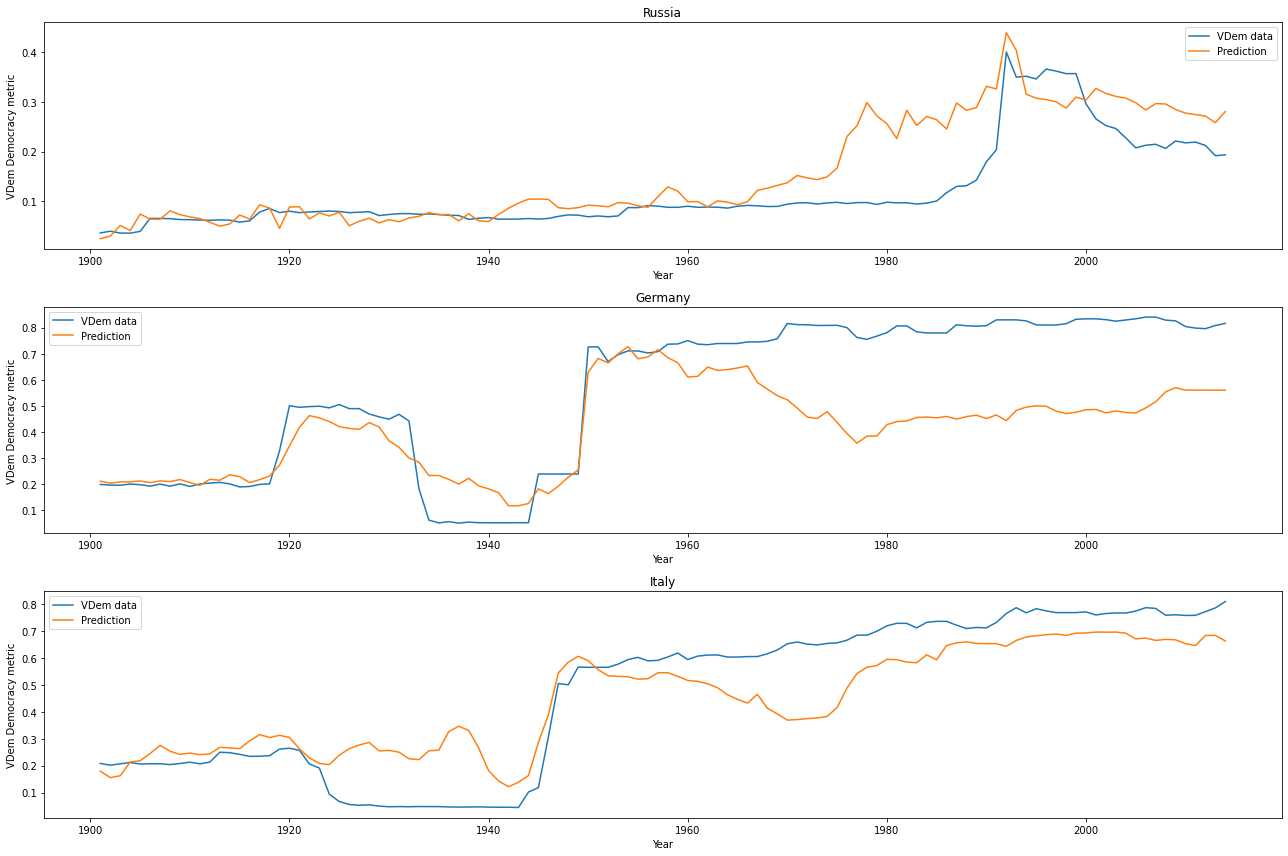

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, figsize=(18, 12))

ax1.plot(years, real_data[:, cty1_idx, 0], label="VDem data")
ax2.plot(years, real_data[:, cty2_idx, 0], label="VDem data")
ax3.plot(years, real_data[:, cty3_idx, 0], label="VDem data")

ax1.plot(years, recur_prediction[:, cty1_idx, 0], label="Prediction")
ax2.plot(years, recur_prediction[:, cty2_idx, 0], label="Prediction")
ax3.plot(years, recur_prediction[:, cty3_idx, 0], label="Prediction")

#ax1.plot(years, non_recur_prediction[:, cty1_idx, 0], label="GraphNet prediction")
#ax2.plot(years, non_recur_prediction[:, cty2_idx, 0], label="GraphNet prediction")
#ax3.plot(years, non_recur_prediction[:, cty3_idx, 0], label="GraphNet prediction")

ax1.set_ylabel("Democracy metric")
ax2.set_ylabel("Democracy metric")
ax3.set_ylabel("Democracy metric")

ax1.set_xlabel("Year")
ax2.set_xlabel("Year")
ax3.set_xlabel("Year")

ax1.title.set_text("Russia".format(cty1))
ax2.title.set_text("Germany".format(cty2))
ax3.title.set_text("Italy".format(cty3))

ax1.legend()
ax2.legend()
ax3.legend()

plt.tight_layout()
plt.show()

In [ ]:
data_export = {}
data_export["russia"] = { "real_data": real_data[:, cty1_idx, 0].tolist(), "prediction": recur_prediction[:, cty1_idx, 0].tolist() }
data_export["germany"] = { "real_data": real_data[:, cty2_idx, 0].tolist(), "prediction": recur_prediction[:, cty2_idx, 0].tolist() }
data_export["italy"] = { "real_data": real_data[:, cty3_idx, 0].tolist(), "prediction": recur_prediction[:, cty3_idx, 0].tolist() }

with open(os.path.join(root, "prediction_data.json"), "w") as f:
    f.write(json.dumps(data_export))